# Marketing Case

Your Hiring manger wants you to develop a tool to optimize their marketing efforts. The Marketing team has collected some data from previous marketing campaign. The data set includes customer information, described below, as a well as whether the customer responded to the marketing campaign or not.

## Data

 Here is the description of each column in the data set:
 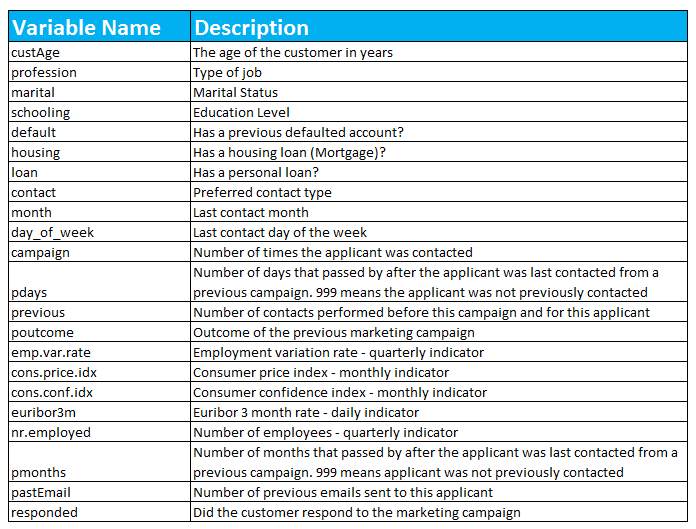
 

## Process

In order to develop the solution we will focus in the following steps

- Getting the Data
- Explore the Data
- Pre-process and clean the data
- Dimensionality reduction
- Build a model:
    - Apply appropiate sampling to split your population
    - Balance complexity and Performance (Variance / Bias)
    - Use sound cross validation techniques
    - Provide the performance measurements of the model
- Deploy the model

### Install required modules

In [32]:
#!pip install pandas_profiling #https://github.com/pandas-profiling/pandas-profiling

## Getting the Data

In [660]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_profiling
from IPython.display import display
import seaborn as sns
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(rc={'figure.figsize':(15,5)})



In [646]:
#data and problem statment is from https://github.com/josuersd19/ELVT_CaseBInterview
#file = 'marketing_training.csv'
file = 'https://raw.githubusercontent.com/josuersd19/ELVT_CaseBInterview/master/marketing_training.csv'
data = pd.read_csv(file)

# Names & Number of rows and columns
print('Number or rows:', data.shape[0])
print('Number or columns:', data.shape[1])
print('Columns Names:       Type')
display(data.dtypes)

Number or rows: 7414
Number or columns: 22
Columns Names:       Type


custAge           float64
profession         object
marital            object
schooling          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
pmonths           float64
pastEmail           int64
responded          object
dtype: object

In [40]:
#print 8 rows of the first 11 variables 
display(data[data.columns[:11]].head(4))
display(data[data.columns[:11]].tail(4))

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,1
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,1
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,1
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,2


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign
7410,45.0,blue-collar,married,basic.4y,unknown,no,no,telephone,jul,tue,3
7411,27.0,blue-collar,single,NaN,no,no,no,cellular,may,fri,2
7412,51.0,unemployed,divorced,high.school,unknown,yes,no,cellular,nov,thu,2
7413,38.0,blue-collar,married,high.school,no,yes,no,telephone,may,fri,1


In [41]:
#print 8 rows of the last 11 variables 
display(data[data.columns[11:]].head(4))
display(data[data.columns[11:]].tail(4))

,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no


,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
7410,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,999.0,0,no
7411,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1,999.0,3,no
7412,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,999.0,0,no
7413,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,999.0,0,no


In [669]:
def plot_histogram(df, targetColumn):
    print(df.name, sorted(set(df)),)
    sns.distplot(df.loc[targetColumn == 'no'], kde=False, color= 'r', label = 'No', bins=40)
    sns.distplot(df.loc[targetColumn == 'yes'], kde=False, color= 'b', label = 'Yes', bins=40)
    plt.legend()
    plt.show()
    
def get_outliers(df):
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    
    IQR = Q3 - Q1

    return [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] 


## Explore the data

Before we start, we will get a quick snapshot of the dataset with the help of <b>pandas_profiling</b> a module that gives much more information than pandas' describe(). 
It provides Quantile Statistics, Descriptive statistics, most frequent values, histograms, correlations and more.

In [129]:
# display(data.describe())
# data.isnull().sum()
#Quick snapshop
print('Computing profiling report')
pfr = pandas_profiling.ProfileReport(data, correlation_overrides =['pmonths'])
pfr.to_file('ProfileReport.html')
pfr

,custAge,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail
count,5610.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000
mean,40.009804,2.518344,960.024548,0.184111,0.052091,93.570708,-40.561316,3.583141,5165.224251,959.797028,0.361883
std,10.574616,2.695055,192.845029,0.516775,1.568399,0.578345,4.649800,1.744865,73.108669,193.969418,1.261668
min,18.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,999.000000,0.000000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,999.000000,0.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,999.000000,0.000000
max,94.000000,40.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,999.000000,18.000000


Number of variables,22
Number of observations,7414
Total Missing (%),2.9%
Total size in memory,1.2 MiB
Average record size in memory,176.0 B
Numeric,9
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,2


There is a lot of information in this report, so first, we will review it and then we will take actions from there.
Number of variables	22
Number of observations	7414

O = outliers, M = Missing, C = Categorical, D = Dirty, N = Normalize, T = Transform 

    campaign O C T
    cons.conf.idx N T
    cons.price.idx N T
    contact C
    custAge O M has 1804 / 24.3% missing values
    day_of_week M C has 711 / 9.6% missing values 
    default C D
    emp.var.rate, euribor3m, nr.employed
    housing, loan, marital, Month
    pastEmail O has 6495 / 87.6% zeros
    pdays, pmonths 999? rest under 1 month
    poutcome 6350 and pdays has 7123?
    previous leave as is, has 6350 / 85.6% zeros
    profession C
    responded Target 88.7/11.3
    schooling C D change missing to unknown has 2155 / 29.1% missing values 

    euribor3m is highly correlated with emp.var.rate (ρ = 0.97095) and was Rejected
    nr.employed is highly correlated with euribor3m (ρ = 0.94255) and was Rejected
    pmonths is highly correlated with pdays (ρ = 0.99999) and was Rejected

    Dataset has 26 duplicate rows 

In [628]:
#Sorting to keep the same order as profiling 
data = data[sorted(data.columns)]
print(data.columns.values)

['campaign' 'cons.conf.idx' 'cons.price.idx' 'contact' 'contacted' 'custAge' 'day_of_week' 'default' 'emp.var.rate' 'euribor3m' 'euribor3m1' 'housing' 'loan' 'marital' 'month' 'nr.employed' 'pastEmail' 'pcontacted' 'pdays' 'pmonths' 'poutcome' 'previous' 'profession' 'responded' 'schooling']


#### campaign

campaign [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 39, 40]


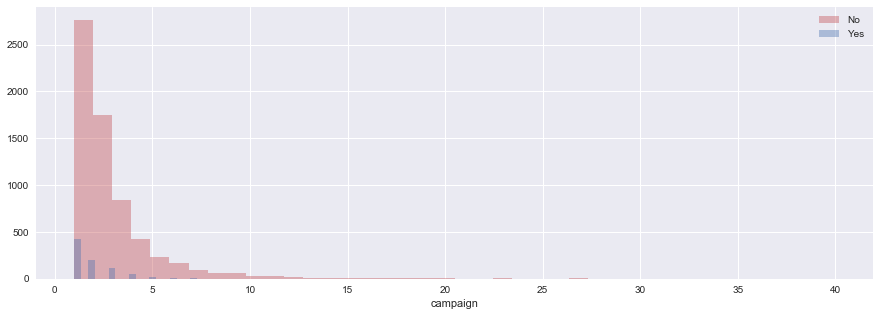

Outliers: [-2.0, 6.0]
Rename all campaings higher than: 6.0 as 7+
campaign1 ['1', '2', '3', '4', '5', '6', '7+']


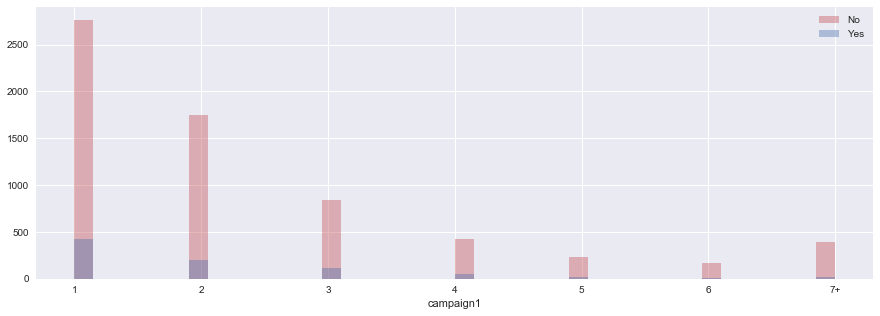

In [672]:
#campaign O C T

dataColumn = 'campaign'

plot_histogram(data[dataColumn], data.responded)

#outliers
outliers = get_outliers(data[dataColumn])
print('Outliers:', outliers)

print('Rename all campaings higher than:',outliers[1], 'as 7+')
data['campaign1'] = data.campaign
data['campaign1'][data['campaign1'] > outliers[1]] = '7+'
data['campaign1'] = data['campaign1'].astype(str)

plot_histogram(data.campaign1, data.responded)


In [502]:

#Nulls and missing data
#schooling
data.schooling.fillna('unknown',inplace=True)

#custAge
data[data.profession=='retired']
data['custAge'] = data.groupby(['marital']).transform(lambda x: x.fillna(round(x.mean())))['custAge']

print('custAge Mean: ',round(data.custAge.mean()))
print('custAge Mean by marital:')
display(round(data[['custAge','profession','marital','schooling']].groupby('marital').mean()))

#day_of_week
data.day_of_week.fillna('unknown',inplace=True)

custAge Mean:  40
custAge Mean by marital:


,custAge
marital,
divorced,45.0
married,42.0
single,33.0
unknown,41.0


In [ ]:
#Are they really correlated?
days_months = data[data.pmonths<100][['pdays','pmonths']]
#small calculation to check errors by comparing both variables
display(sum(days_months.pdays - days_months.pmonths*30))
print('pdays','pmonths','are very correlated')

#too many 999s
#data['pcontacted'] = data.pdays == 999 
data.drop(['pdays','pmonths'], axis=1, inplace=True)

In [423]:
data.drop_duplicates(inplace=True)
data.columns

Index(['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail',
       'responded'],
      dtype='object')

Column to remove: Reason
- pdays, pmonths:  96% of 999 values

In [ ]:
data.marital

In [ ]:
pandas_profiling.ProfileReport(data)

## Model with H2O

In [513]:
        
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.101-b13, mixed mode, sharing)


C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\server.py:331: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\gsaez\AppData\Local\Temp\tmpviewj9nq
  JVM stdout: C:\Users\gsaez\AppData\Local\Temp\tmpviewj9nq\h2o_gsaez_started_from_python.out
  JVM stderr: C:\Users\gsaez\AppData\Local\Temp\tmpviewj9nq\h2o_gsaez_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,3 months and 27 days !!!
H2O cluster name:,H2O_from_python_gsaez_44o1ax
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [514]:
mrk = h2o.H2OFrame(data)
mrk.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:7414
Cols:24




,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,contacted,pcontacted
type,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,int,int,enum,real,real,real,real,real,real,int,enum,enum,enum
mins,18.0,,,,,,,,,,1.0,0.0,0.0,,-3.4,92.201,-50.8,0.634,4963.6,0.0,0.0,,,
mean,39.94469921769622,,,,,,,,,,2.5183436741300227,960.0245481521447,0.18411114108443422,,0.05209063933099537,93.57070825465323,-40.56131642837874,3.583140679794994,5165.2242514162335,959.7970281449491,0.3618829241974643,,,
maxs,94.0,,,,,,,,,,40.0,999.0,6.0,,1.4,94.767,-26.9,5.045,5228.1,999.0,18.0,,,
sigma,9.45122680963181,,,,,,,,,,2.6950550833158977,192.84502875881603,0.5167748948780534,,1.5683992615954492,0.5783445077242826,4.649799723448907,1.7448646339732052,73.10866942298355,193.96941793390158,1.2616684908756743,,,
zeros,0,,,,,,,,,,0,2,6350,,0,0,0,0,0,2,6495,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,1.0,999.0,0.0,nonexistent,-0.1,93.2,-42.0,4.191,5195.8,999.0,0.0,no,True,True
1,42.0,blue-collar,married,unknown,no,no,no,cellular,jul,mon,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.96,5228.1,999.0,0.0,no,True,True
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0.0,no,True,True


In [515]:
categorical_variables = ['profession','marital','schooling','default', 
                         'housing', 'loan', 'contact', 'month','day_of_week','poutcome','responded', 'pcontacted']
for variable in categorical_variables:
    mrk[variable] = mrk[variable].asfactor() 
    
predictors = mrk.columns
predictors.remove('responded')
response = 'responded'

In [517]:
train, valid = mrk.split_frame(ratios=[.8], seed=25)

In [476]:
bin_num = [8]#,16,32,2048]

for key, num in enumerate(bin_num):
    mrk_gbm = H2OGradientBoostingEstimator(nbins_cats = num, seed = 25)
    mrk_gbm.train(x = predictors, y= response, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [518]:
bin_num = [8]#,16,32,2048]
#with 999 as true
for key, num in enumerate(bin_num):
    mrk_gbm2 = H2OGradientBoostingEstimator(nbins_cats = num, seed = 25)
    mrk_gbm2.train(x = predictors, y= response, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [500]:
print(str(num), mrk_gbm.auc(train=True))
print(str(num), mrk_gbm.auc(valid=True))
#print(mrk_gbm.aic)
#print(mrk_gbm.confusion_matrix)
#print(mrk_gbm.coef)
pd.DataFrame(mrk_gbm.varimp(), columns=['Columns','','',''])

8 0.8726263015166226
8 0.8064490598618572


,Column,,,
0,nr.employed,416.509613,1.000000,0.372178
1,poutcome,114.375214,0.274604,0.102202
2,euribor3m,111.737648,0.268271,0.099845
3,day_of_week,85.439262,0.205132,0.076345
4,schooling,65.600113,0.157500,0.058618
5,cons.conf.idx,65.525368,0.157320,0.058551
6,custAge,57.460442,0.137957,0.051345
7,profession,35.471909,0.085165,0.031696
8,month,33.780003,0.081103,0.030185
9,pastEmail,24.365461,0.058499,0.021772


In [520]:
print(str(num), mrk_gbm2.auc(train=True))
print(str(num), mrk_gbm2.auc(valid=True))
#print(mrk_gbm.aic)
#print(mrk_gbm.confusion_matrix)
#print(mrk_gbm.coef)
pd.DataFrame(mrk_gbm2.varimp(), columns=['Columns','','',''])

8 0.8724768991261843
8 0.8014989447429011


,Columns,,,
0,nr.employed,421.452454,1.000000,0.374026
1,euribor3m,108.525894,0.257504,0.096313
2,day_of_week,95.702103,0.227077,0.084933
3,poutcome,72.077469,0.171022,0.063966
4,cons.conf.idx,67.583313,0.160358,0.059978
5,schooling,66.718452,0.158306,0.059210
6,custAge,60.590519,0.143766,0.053772
7,pdays,48.129738,0.114200,0.042714
8,month,33.410618,0.079275,0.029651
9,cons.price.idx,23.293768,0.055270,0.020672


0.8726263015166226
0.8064490598618572


In [673]:
h2o.cluster().shutdown()

H2O session _sid_8f13 closed.


Get creative with data engineering
Get creative with dimensionality reduction

Build a model:
  -  Apply appropiate sampling to split your population
  -  Balance complexity and Performance (Variance / Bias)
  -  Use sound cross validation techniques
  -  Provide the performance measurements of the model